# Capstone Project - Move to a metropolis

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

New York City (NYC), Toronto, and Shanghai are all the financial centers of their respective countries, and are all among the top 10 financial centers around the world.<sup>1</sup> However, residents in the three cities are of different cultural backgrounds. Historically NYC and Toronto served as destinations for immigrants mostly from Europe, but there are mostly Chinese people living in Shanghai while it serves as an important trading port.<sup>2-4</sup> Everyone has the right to choose where to live and pursue their dreams. As a person from a less developed city, I am curious to learn more about lives in the three big cities.

The goal of this project is to find out the similarity and difference between the three big cities and hopefully the result can help people decide which one of the three is likely to be a better new home.

## Data <a name="data"></a>

In this project, we will be using the neighborhood information from the previous module for NYC and Toronto, together with the new information of neighborhoods in Shanghai from Wikipedia.<sup>5</sup> Foursquare location data will be used to obtain ventures around the neighborhoods.

We want all types of venues around each neighborhood to tell us about the types of food, transportation, and relaxation. These places contain hints of people's life styles. We want to see if it will be convenient to find things. As will be noticed later, the number of districts in Shanghai is intrinsically smaller than the other two cities. So the radius of search is increased from 500 to 1000 as compensation.

During preparation of data, I realized that some information such as the universities in Shanghai could not be aquired very precisely by Foursquare. It might be because of the translation of names or other language related reasons. I would like to use the distribution of universities in Shanghai as an example for discussion, so the list of univeristies is aquired seperately from Wikipedia.<sup>6</sup> Still, some names in the list have to be manually filtered out in order to avoid error. Data of average temperature by month will be imported manually from other sources since automatic access is forbidden.<sup>7-9</sup>

### Neighborhood data

First, import libraries for data acquisition and processing.

In [37]:
import pandas as pd
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge geocoder --yes
import geocoder # import geocoder

import requests # library to handle requests

#import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### NYC manhattan data
We are going to download the data as what we practiced before, and generate a dataframe containing the coordinates of each neighborhood. Then, all the neighborhoods will be marked on the map.

In [22]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [23]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [24]:
print(type(newyork_data))
neighborhoods_data = newyork_data['features']
print(type(neighborhoods_data))

<class 'dict'>
<class 'list'>


In [25]:
# define the dataframe columns
ny_column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
ny_neighborhoods = pd.DataFrame(columns=ny_column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_neighborhoods = ny_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
ny_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [26]:
manhattan_data = ny_neighborhoods[ny_neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [27]:
address1 = 'Manhattan, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address1)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [28]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[40.7896239, -73.9598939], zoom_start=12)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

#### Toronto main area data
We are going to read the table from the webpage, and generate a dataframe containing the coordinates of each neighborhood. Then, all the neighborhoods will be marked on the map.

In [13]:
toronto_data = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
toronto_data_df = toronto_data[0]
toronto_data2 = toronto_data_df.drop(toronto_data_df[toronto_data_df['Borough']=='Not assigned'].index, axis=0)
toronto_data3 = toronto_data2.copy()
type(toronto_data3)

pandas.core.frame.DataFrame

In [14]:
# toronto_data3.reset_index()
toronto_data_group = toronto_data3.groupby(['Postcode']).agg(lambda x: ", ".join(sorted(set(x))))
toronto_data_group.reset_index()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [15]:
toronto_data_group['Neighbourhood'].replace("Not assigned", toronto_data_group["Borough"],inplace=True)
toronto_data_group.reset_index(inplace=True)
#toronto_data_group.drop(['index'],axis=1,inplace=True)
toronto_data_group.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [16]:
toronto_data_group.shape

(103, 3)

In [17]:
postcode_df = pd.read_csv('https://cocl.us/Geospatial_data')
postcode_df.rename(columns={'Postal Code':'Postcode'}, inplace=True)
postcode_df.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [18]:
toronto_data_merged = toronto_data_group
toronto_data_merged = toronto_data_merged.join(postcode_df.set_index('Postcode'), on='Postcode')
toronto_data_merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [19]:
toronto_data_filtered = toronto_data_merged.copy()
for i in range(0, len(toronto_data_filtered['Postcode'])):
    if 'Toronto' not in toronto_data_filtered.ix[i,'Borough']:
        #print(toronto_data_filtered.ix[i,'Borough'])
        #print(i)
        toronto_data_filtered.drop([i], inplace=True)
toronto_data_filtered.reset_index(inplace=True)
toronto_data_filtered.drop(['index'],axis=1,inplace=True)
toronto_data_filtered.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [20]:
address2 = 'Toronto, Ontario, Canada'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address2)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [21]:
# create map of Manhattan using latitude and longitude values
map_toronto = folium.Map(location=[43.653963, -79.387207], zoom_start=12)

# add markers to map
for lat, lng, label in zip(toronto_data_filtered['Latitude'], toronto_data_filtered['Longitude'], toronto_data_filtered['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Shanghai main area data
We are going to read the table from the webpage, and generate a dataframe containing the coordinates of each neighborhood. Then, all the neighborhoods will be marked on the map.

In [5]:
sh_district_data = pd.read_html('https://en.wikipedia.org/wiki/List_of_administrative_divisions_of_Shanghai')
sh_district_data_df = sh_district_data[3]
print(type(sh_district_data_df))
print(sh_district_data_df.shape)
sh_district_data_df.head()

<class 'pandas.core.frame.DataFrame'>
(16, 9)


Unnamed: 0_level_0                    County Level                        \
  Unnamed: 0_level_1                            Name Chinese  Hanyu Pinyin   
0                NaN  Huangpu District[5](City seat)     黄浦区    Huángpǔ Qū   
1                NaN                  Xuhui District     徐汇区      Xúhuì Qū   
2                NaN              Changning District     长宁区  Chángníng Qū   
3                NaN                Jing'an District     静安区    Jìng'ān Qū   
4                NaN                  Putuo District     普陀区      Pǔtuó Qū   

                                                     \
  Division code[2] Division code[2].1 Area (km²)[3]   
0           310101                HGP         20.46   
1           310104                XHI         54.76   
2           310105                CNQ         38.30   
3           310106                JAQ         37.37   
4           310107                PTQ         54.83   

                                              
  Population (2015 census)[4] Density (/km²)  
0                      658600          32190  
1                     1089100          19889  
2                      691100          18044  
3                     1000000          27000  
4                     1288000          23491

In [6]:
district_info = sh_district_data_df['County Level']['Name'].to_frame()
district_info.rename(columns={'Name':'Neighborhood'}, inplace=True)
for i in range(0,len(district_info['Neighborhood'])):
    district_info.iloc[i,0] = district_info.iloc[i,0].rsplit(' District', 1)[0]
district_info

,Neighborhood
0,Huangpu
1,Xuhui
2,Changning
3,Jing'an
4,Putuo
5,Hongkou
6,Yangpu
7,Minhang
8,Baoshan
9,Jiading


In [12]:
district_info['Latitude'] = 0
district_info['Longitude'] = 0

for i in range(0,len(district_info['Neighborhood'])):
    address = '{}, Shanghai, China'.format(district_info.iloc[i,0])
    #print(address)
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    district_info.iloc[i,1] = latitude
    district_info.iloc[i,2] = longitude
    #print('The geograpical coordinates of {} district are {}, {}.'.format(district_info.iloc[i,0],latitude, longitude))
district_info.drop(index=15, axis=0, inplace=True)    
district_info.head()

,Neighborhood,Latitude,Longitude
0,Huangpu,31.233593,121.479864
1,Xuhui,31.163698,121.427994
2,Changning,31.209276,121.389986
3,Jing'an,31.229776,121.443060
4,Putuo,31.251326,121.391229


In [13]:
address3 = 'Shanghai, China'
geolocator = Nominatim(user_agent="sh_explorer")
location = geolocator.geocode(address3)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Shanghai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Shanghai are 31.2322758, 121.4692071.


In [14]:
# create map of Shanghai using latitude and longitude values
map_sh = folium.Map(location=[31.2322758, 121.4692071], zoom_start=10)

# add markers to map
for lat, lng, label in zip(district_info['Latitude'], district_info['Longitude'], district_info['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sh)  
    
map_sh

### Venue data
Next, we will need to use Foursquare location data to find out the venues around the neighborhoods.

In [15]:
CLIENT_ID = 'KAMEMLBI2F4LUL2QDJKG3Z2EFYUOXU5H5B2LNQN25USIFBON' # your Foursquare ID
CLIENT_SECRET = '2SWPL53GOW0YI252BYKHQACJMHLGSJG2I55EUBBQNJMO3SDE' # your Foursquare Secret
VERSION = '20200127' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KAMEMLBI2F4LUL2QDJKG3Z2EFYUOXU5H5B2LNQN25USIFBON
CLIENT_SECRET:2SWPL53GOW0YI252BYKHQACJMHLGSJG2I55EUBBQNJMO3SDE


Create a function to explore all the neighborhoods.

In [16]:
LIMIT = 100
#radius = 500
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### NYC manhattan venue data

In [29]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
manhattan_venues.groupby('Neighborhood').count()

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,97,97,97,97,97,97
Carnegie Hill,100,100,100,100,100,100
Central Harlem,46,46,46,46,46,46
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,40,40,40,40,40,40
East Village,100,100,100,100,100,100


#### Toronto main area venue data

In [31]:
toronto_venues = getNearbyVenues(names=toronto_data_filtered['Neighbourhood'], 
                                 latitudes=toronto_data_filtered['Latitude'], 
                                 longitudes=toronto_data_filtered['Longitude'])
toronto_venues.groupby('Neighborhood').count()

The Beaches
Riverdale, The Danforth West
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
North Midtown, The Annex, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
Bathurst Quay, CN Tower, Harbourfront West, Island airport, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction Sout

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
"Bathurst Quay, CN Tower, Harbourfront West, Island airport, King and Spadina, Railway Lands, South Niagara",17,17,17,17,17,17
Berczy Park,55,55,55,55,55,55
"Brockton, Exhibition Place, Parkdale Village",22,22,22,22,22,22
Business Reply Mail Processing Centre 969 Eastern,15,15,15,15,15,15
"Cabbagetown, St. James Town",43,43,43,43,43,43
Central Bay Street,83,83,83,83,83,83
"Chinatown, Grange Park, Kensington Market",86,86,86,86,86,86
Christie,18,18,18,18,18,18


#### Shanghai main area venue data

In [17]:
sh_venues = getNearbyVenues(names=district_info['Neighborhood'], 
                            latitudes=district_info['Latitude'], 
                            longitudes=district_info['Longitude'], radius = 1000)
sh_venues.groupby('Neighborhood').count()

Huangpu
Xuhui
Changning
Jing'an
Putuo
Hongkou
Yangpu
Minhang
Baoshan
Jiading
Pudong New Area
Jinshan
Songjiang
Qingpu
Fengxian


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Baoshan,2,2,2,2,2,2
Changning,65,65,65,65,65,65
Fengxian,10,10,10,10,10,10
Hongkou,33,33,33,33,33,33
Huangpu,100,100,100,100,100,100
Jiading,13,13,13,13,13,13
Jing'an,100,100,100,100,100,100
Jinshan,3,3,3,3,3,3
Minhang,13,13,13,13,13,13


In addition, we will import a list of universities in Shanghai.

In [33]:
sh_univ_data = pd.read_html('https://en.wikipedia.org/wiki/List_of_universities_and_colleges_in_Shanghai')
sh_univ_data_df = sh_univ_data[0]
print(type(sh_univ_data_df))
print(sh_univ_data_df.shape)
sh_univ_data_df.head()

<class 'pandas.core.frame.DataFrame'>
(36, 4)


,Name,Chinese name,Type,Note
0,Fudan University,复旦大学,National (Direct),Ω
1,Tongji University,同济大学,National (Direct),Ω
2,Shanghai Jiao Tong University,上海交通大学,National (Direct),Ω
3,East China University of Science and Technology,华东理工大学,National (Direct),Ω
4,University of Shanghai for Science and Technology,上海理工大学,Municipal,NaN


In [34]:
univ_info = sh_univ_data_df['Name'].to_frame()
univ_info.rename(columns={'Name':'University'}, inplace=True)
univ_info.drop(index=[8,10,20,25,27,30,32,33,35], inplace=True)
univ_info.reset_index(inplace=True)
univ_info.drop(['index'],axis=1,inplace=True)
univ_info

,University
0,Fudan University
1,Tongji University
2,Shanghai Jiao Tong University
3,East China University of Science and Technology
4,University of Shanghai for Science and Technology
5,Shanghai Maritime University
6,Donghua University
7,Shanghai Institute of Technology
8,Shanghai Ocean University
9,East China Normal University


In [35]:
univ_info['Latitude'] = 0
univ_info['Longitude'] = 0

for i in range(0,len(univ_info['University'])):
    address = '{}, China'.format(univ_info.iloc[i,0])
    #print(address)
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    univ_info.iloc[i,1] = latitude
    univ_info.iloc[i,2] = longitude
    #print('The geograpical coordinates of {} district are {}, {}.'.format(district_info.iloc[i,0],latitude, longitude))
    
univ_info.head()

,University,Latitude,Longitude
0,Fudan University,31.301044,121.500455
1,Tongji University,31.284739,121.496949
2,Shanghai Jiao Tong University,31.200815,121.428407
3,East China University of Science and Technology,31.145081,121.419509
4,University of Shanghai for Science and Technology,31.295016,121.550674


#### Monthly temperature data

Import the annual average temperature data of the three cities and generate a dataframe.

In [38]:
temp_data = [['Jan', 33, 26, 39], ['Feb', 36, 28, 43], ['Mar', 43, 35, 48], ['Apr', 53, 46, 59],
            ['May', 63, 58, 68], ['Jun', 72, 67, 75], ['Jul', 77, 72, 84], ['Aug', 76, 71, 84],
            ['Sep', 68, 68, 75], ['Oct', 57, 51, 66], ['Nov', 48, 41, 55], ['Dec', 38, 31, 45]]
temp_df = pd.DataFrame(temp_data, columns = ['Month', 'NYC', 'Toronto', 'Shanghai'])
temp_df

,Month,NYC,Toronto,Shanghai
0,Jan,33,26,39
1,Feb,36,28,43
2,Mar,43,35,48
3,Apr,53,46,59
4,May,63,58,68
5,Jun,72,67,75
6,Jul,77,72,84
7,Aug,76,71,84
8,Sep,68,68,75
9,Oct,57,51,66


A bar chart will be a straightforward way to present the data and show the contrast between the three data sets.

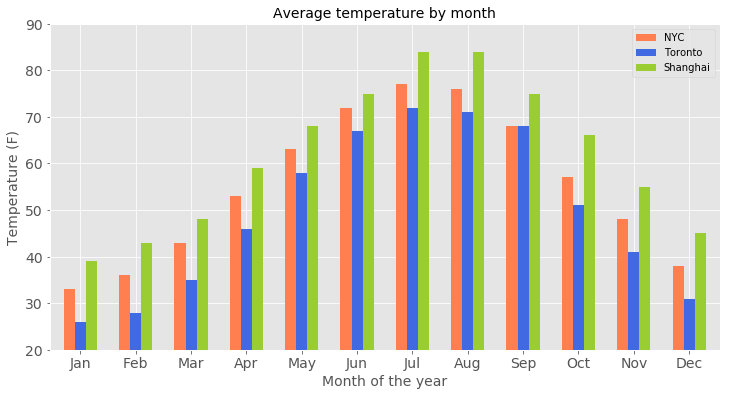

In [39]:
plt.style.use('ggplot')
temp_df.plot(kind='bar', x='Month', figsize=(12, 6), width=0.6, align='center', rot=0, fontsize=14,
             color=['coral', 'royalblue', 'yellowgreen'])

plt.xlabel('Month of the year', fontsize=14) # add to x-label to the plot
plt.ylabel('Temperature (F)', fontsize=14) # add y-label to the plot
plt.title('Average temperature by month', fontsize=14) # add title to the plot
plt.ylim(bottom=20, top=90)

plt.show()

Now we have got the venue data that will be analyzed later, which will tell us more about lives in the three big cities.

## Methodology <a name="methodology"></a>

In this project, we first collected the names of neighborhoods in NYC, Toronto, and Shanghai by reading tables from the webpages or downloading a json file. The geographic coordinates are obtained with **Nominatim** and **geocoder** by providing the address strings. Some remote neighborhoods are excluded from the data sets since we are focusing on the main areas of the cities. We also marked the locations of the neighborhoods on the maps created with **folium**. A bar graph is created with **matplotlib.pyplot** to show the temperature distribution profile.

**Foursquare API** was used to acquire venue data 500 m around each neighborhood in NYC Manhattan and Toronto, and 1000 m for those in Shanghai. The name, location, and category information of the venuess are stored in dataframes. The frequency of occurrence of each category in each neighborhood was found with the **groupby** function. Since we are looking for an ideal home, we specifically looked for some food and culture related key words in the venue types by building **for loops**.

Finally, the neighborhoods are divided into clusters with **kmeans clustering**. The best value of k is found by using the **elbow method**, although there is no very sharp turning point since the whole area is developed. Different clusters are marked on maps and we will try to find the common features among the neighborhoods in the same cluster. The locations of universities in Shanghai will be appended into the map of Shanghai to help us gain some understanding of the area.

## Analysis <a name="analysis"></a>

First is to find out how many unique categories can be curated from all the returned venues.

In [45]:
print('There are {} uniques categories in NYC.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 337 uniques categories in NYC.


In [47]:
print('There are {} uniques categories in Toronto.'.format(len(toronto_venues['Venue Category'].unique())))

There are 231 uniques categories in Toronto.


In [49]:
print('There are {} uniques categories in Shanghai.'.format(len(sh_venues['Venue Category'].unique())))

There are 117 uniques categories in Shanghai.


Next we are going to analysis the data of each city.

#### NYC manhattan data

In [30]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]
print(manhattan_onehot.shape)
manhattan_onehot.head()

(3309, 338)


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [31]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,0.000000,0.00,0.00,0.000000,0.010309,0.00,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.030928,0.000000,0.030928,0.000000
1,Carnegie Hill,0.000000,0.00,0.00,0.000000,0.010000,0.00,0.00,0.000000,0.010000,...,0.020000,0.00,0.000000,0.00,0.00,0.010000,0.030000,0.000000,0.010000,0.030000
2,Central Harlem,0.000000,0.00,0.00,0.065217,0.043478,0.00,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,Chelsea,0.000000,0.00,0.00,0.000000,0.030000,0.00,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.030000,0.000000,0.010000,0.010000
4,Chinatown,0.000000,0.00,0.00,0.000000,0.040000,0.00,0.00,0.000000,0.000000,...,0.040000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.010000
5,Civic Center,0.000000,0.00,0.00,0.000000,0.030000,0.01,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.020000,0.020000,0.000000,0.000000,0.030000
6,Clinton,0.000000,0.00,0.00,0.000000,0.040000,0.00,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.020000,0.030000,0.000000,0.000000,0.000000
7,East Harlem,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
8,East Village,0.000000,0.00,0.00,0.000000,0.020000,0.00,0.00,0.010000,0.010000,...,0.020000,0.00,0.000000,0.00,0.00,0.050000,0.010000,0.000000,0.000000,0.000000
9,Financial District,0.010000,0.00,0.00,0.000000,0.050000,0.00,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.030000,0.000000,0.010000,0.000000


Define some daily life related key words, and search for related venues in the area.

In [32]:
manhattan_venue_type = list(manhattan_grouped.columns.values)

food_words = ['Restaurant', 'Diner', 'Tavern', 'Steakhouse']
culture_words = ['Art', 'Museum', 'Antique', 'Music', 'Gallery', 'Book']

In [195]:
manhattan_food = []
manhattan_culture = []
for i in range(0, len(manhattan_venue_type)):
    #print(manhattan_venue_type[i])
    for food in food_words:
        if food in manhattan_venue_type[i]:
            manhattan_food.append(manhattan_venue_type[i])
    for culture in culture_words:
        if culture in manhattan_venue_type[i]:
            manhattan_culture.append(manhattan_venue_type[i])

print('You can find the following types of food @NYC:')
print(manhattan_food)
print('\n')
print('You can find the following types of cultural places @NYC:')
print(manhattan_culture)

You can find the following types of food @NYC:
['Afghan Restaurant', 'African Restaurant', 'American Restaurant', 'Arepa Restaurant', 'Argentinian Restaurant', 'Asian Restaurant', 'Australian Restaurant', 'Austrian Restaurant', 'Brazilian Restaurant', 'Cajun / Creole Restaurant', 'Cambodian Restaurant', 'Caribbean Restaurant', 'Caucasian Restaurant', 'Chinese Restaurant', 'Cuban Restaurant', 'Czech Restaurant', 'Dim Sum Restaurant', 'Diner', 'Dumpling Restaurant', 'Eastern European Restaurant', 'Empanada Restaurant', 'English Restaurant', 'Ethiopian Restaurant', 'Falafel Restaurant', 'Fast Food Restaurant', 'Filipino Restaurant', 'French Restaurant', 'German Restaurant', 'Greek Restaurant', 'Hawaiian Restaurant', 'Himalayan Restaurant', 'Hotpot Restaurant', 'Indian Restaurant', 'Israeli Restaurant', 'Italian Restaurant', 'Japanese Curry Restaurant', 'Japanese Restaurant', 'Jewish Restaurant', 'Kebab Restaurant', 'Korean Restaurant', 'Kosher Restaurant', 'Latin American Restaurant', 'Le

Print each neighborhood along with the top 5 most common venues.

In [165]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
           venue  freq
0           Park  0.07
1    Coffee Shop  0.05
2          Hotel  0.05
3            Gym  0.04
4  Memorial Site  0.03


----Carnegie Hill----
            venue  freq
0     Coffee Shop  0.07
1     Pizza Place  0.05
2  Cosmetics Shop  0.04
3       Bookstore  0.03
4   Grocery Store  0.03


----Central Harlem----
                 venue  freq
0   African Restaurant  0.07
1                  Bar  0.04
2  Fried Chicken Joint  0.04
3  American Restaurant  0.04
4   Chinese Restaurant  0.04


----Chelsea----
                venue  freq
0         Coffee Shop  0.06
1              Bakery  0.05
2      Ice Cream Shop  0.04
3  Italian Restaurant  0.04
4               Hotel  0.03


----Chinatown----
                   venue  freq
0     Chinese Restaurant  0.10
1    American Restaurant  0.04
2           Cocktail Bar  0.04
3           Optical Shop  0.03
4  Vietnamese Restaurant  0.03


----Civic Center----
                  venue  freq
0  Gym / Fitness Center 

Write a function to sort the venues in descending order.

In [167]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [178]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Coffee Shop,Gym,Women's Store,Memorial Site,Wine Shop,Ice Cream Shop,Grocery Store,Italian Restaurant
1,Carnegie Hill,Coffee Shop,Pizza Place,Cosmetics Shop,Yoga Studio,Grocery Store,Bookstore,Café,Bakery,French Restaurant,Gym
2,Central Harlem,African Restaurant,Cosmetics Shop,Chinese Restaurant,Fried Chicken Joint,French Restaurant,Seafood Restaurant,American Restaurant,Bar,Event Space,Ethiopian Restaurant
3,Chelsea,Coffee Shop,Bakery,Ice Cream Shop,Italian Restaurant,Nightclub,American Restaurant,Hotel,Theater,Bookstore,Burger Joint
4,Chinatown,Chinese Restaurant,Cocktail Bar,American Restaurant,Salon / Barbershop,Bakery,Optical Shop,Spa,Vietnamese Restaurant,Hotpot Restaurant,Asian Restaurant


Build a for loop to search for the optimal number for k-means clustering.

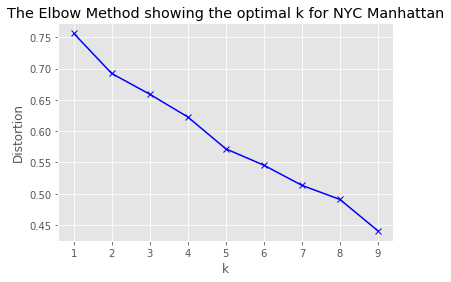

In [171]:
# clustering dataset
# determine k using elbow method
manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(manhattan_grouped_clustering)
    distortions.append(kmeans.inertia_)

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k for NYC Manhattan')
plt.show()

Although there is not a sharp elbow, k = 5 seems to be our best candidate.

In [176]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 4, 1, 4, 1, 1, 2, 0, 4, 1], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [179]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,1,Sandwich Place,Coffee Shop,Yoga Studio,Deli / Bodega,Supplement Shop,Steakhouse,Shopping Mall,Seafood Restaurant,Pizza Place,Department Store
1,Manhattan,Chinatown,40.715618,-73.994279,1,Chinese Restaurant,Cocktail Bar,American Restaurant,Salon / Barbershop,Bakery,Optical Shop,Spa,Vietnamese Restaurant,Hotpot Restaurant,Asian Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,0,Café,Bakery,Grocery Store,Mobile Phone Shop,Supplement Shop,Tapas Restaurant,Pizza Place,Spanish Restaurant,Park,Deli / Bodega
3,Manhattan,Inwood,40.867684,-73.921210,0,Mexican Restaurant,Restaurant,Café,Lounge,Frozen Yogurt Shop,Bakery,Wine Bar,Pizza Place,American Restaurant,Deli / Bodega
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Pizza Place,Coffee Shop,Café,Deli / Bodega,Mexican Restaurant,Bakery,Park,Cocktail Bar,Sandwich Place,School


Visualize the resulting clusters.

In [182]:
# create map
map_clusters1 = folium.Map(location=[40.7896239, -73.9598939], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters1)
       
map_clusters1

Now, we can examine each cluster in NYC Manhattan.

#### NYC - Cluster 1

In [183]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Washington Heights,Café,Bakery,Grocery Store,Mobile Phone Shop,Supplement Shop,Tapas Restaurant,Pizza Place,Spanish Restaurant,Park,Deli / Bodega
3,Inwood,Mexican Restaurant,Restaurant,Café,Lounge,Frozen Yogurt Shop,Bakery,Wine Bar,Pizza Place,American Restaurant,Deli / Bodega
4,Hamilton Heights,Pizza Place,Coffee Shop,Café,Deli / Bodega,Mexican Restaurant,Bakery,Park,Cocktail Bar,Sandwich Place,School
5,Manhattanville,Deli / Bodega,Coffee Shop,Italian Restaurant,Mexican Restaurant,Park,Seafood Restaurant,Japanese Curry Restaurant,Ramen Restaurant,Boutique,Supermarket
7,East Harlem,Mexican Restaurant,Bakery,Thai Restaurant,Latin American Restaurant,Deli / Bodega,Taco Place,Grocery Store,Donut Shop,Cocktail Bar,Liquor Store
25,Manhattan Valley,Bar,Coffee Shop,Yoga Studio,Indian Restaurant,Mexican Restaurant,Thai Restaurant,Pizza Place,Playground,Cosmetics Shop,Dog Run
36,Tudor City,Café,Park,Pizza Place,Mexican Restaurant,Deli / Bodega,Greek Restaurant,Coffee Shop,Diner,Garden,Dog Run


#### NYC - Cluster 2

In [184]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Sandwich Place,Coffee Shop,Yoga Studio,Deli / Bodega,Supplement Shop,Steakhouse,Shopping Mall,Seafood Restaurant,Pizza Place,Department Store
1,Chinatown,Chinese Restaurant,Cocktail Bar,American Restaurant,Salon / Barbershop,Bakery,Optical Shop,Spa,Vietnamese Restaurant,Hotpot Restaurant,Asian Restaurant
6,Central Harlem,African Restaurant,Cosmetics Shop,Chinese Restaurant,Fried Chicken Joint,French Restaurant,Seafood Restaurant,American Restaurant,Bar,Event Space,Ethiopian Restaurant
11,Roosevelt Island,Sandwich Place,Hotpot Restaurant,Dry Cleaner,Liquor Store,Metro Station,Supermarket,Bubble Tea Shop,Monument / Landmark,Bus Line,Soccer Field
15,Midtown,Hotel,Clothing Store,Coffee Shop,Theater,Sporting Goods Shop,Japanese Restaurant,Bakery,Steakhouse,American Restaurant,Bookstore
16,Murray Hill,Sandwich Place,Coffee Shop,American Restaurant,Japanese Restaurant,Hotel,Gym / Fitness Center,Italian Restaurant,Chinese Restaurant,Bagel Shop,Bar
26,Morningside Heights,Park,Coffee Shop,Bookstore,American Restaurant,Burger Joint,Sandwich Place,Food Truck,Deli / Bodega,Donut Shop,New American Restaurant
28,Battery Park City,Park,Hotel,Coffee Shop,Gym,Women's Store,Memorial Site,Wine Shop,Ice Cream Shop,Grocery Store,Italian Restaurant
29,Financial District,Coffee Shop,American Restaurant,Food Truck,Hotel,Bar,Pizza Place,Gym,Steakhouse,Gym / Fitness Center,Wine Shop
32,Civic Center,Gym / Fitness Center,Hotel,Coffee Shop,French Restaurant,Italian Restaurant,Yoga Studio,Cocktail Bar,Sandwich Place,Spa,Park


#### NYC - Cluster 3

In [185]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Lincoln Square,Theater,Café,Plaza,Concert Hall,Italian Restaurant,Performing Arts Venue,French Restaurant,Gym,Gym / Fitness Center,American Restaurant
14,Clinton,Theater,Gym / Fitness Center,Spa,American Restaurant,Italian Restaurant,Coffee Shop,Sandwich Place,Wine Shop,Gym,Hotel
21,Tribeca,American Restaurant,Park,Italian Restaurant,Café,Spa,Wine Shop,Wine Bar,Coffee Shop,Greek Restaurant,Men's Store
39,Hudson Yards,American Restaurant,Italian Restaurant,Hotel,Gym / Fitness Center,Café,Coffee Shop,Burger Joint,Spanish Restaurant,Park,Thai Restaurant


#### NYC - Cluster 4

In [186]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Park,Bar,Baseball Field,Pet Service,Gas Station,Farmers Market,Boat or Ferry,German Restaurant,Gym / Fitness Center,Harbor / Marina


#### NYC - Cluster 5

In [187]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Upper East Side,Italian Restaurant,Exhibit,Bakery,Gym / Fitness Center,Juice Bar,Art Gallery,Coffee Shop,French Restaurant,Hotel,American Restaurant
9,Yorkville,Italian Restaurant,Bar,Coffee Shop,Gym,Deli / Bodega,Pizza Place,Sushi Restaurant,Japanese Restaurant,Diner,Wine Shop
10,Lenox Hill,Coffee Shop,Italian Restaurant,Pizza Place,Sushi Restaurant,Cocktail Bar,Burger Joint,Café,Gym,Gym / Fitness Center,Sporting Goods Shop
12,Upper West Side,Italian Restaurant,Bar,Wine Bar,Coffee Shop,Indian Restaurant,Bakery,Café,Mediterranean Restaurant,Gym / Fitness Center,Ice Cream Shop
17,Chelsea,Coffee Shop,Bakery,Ice Cream Shop,Italian Restaurant,Nightclub,American Restaurant,Hotel,Theater,Bookstore,Burger Joint
18,Greenwich Village,Italian Restaurant,Clothing Store,Sushi Restaurant,Café,Indian Restaurant,Seafood Restaurant,French Restaurant,Dessert Shop,Gourmet Shop,Sandwich Place
19,East Village,Bar,Wine Bar,Ice Cream Shop,Chinese Restaurant,Mexican Restaurant,Cocktail Bar,Pizza Place,Vegetarian / Vegan Restaurant,Italian Restaurant,Speakeasy
20,Lower East Side,Café,Coffee Shop,Art Gallery,Pizza Place,Japanese Restaurant,Cocktail Bar,Bakery,Ramen Restaurant,Park,Chinese Restaurant
22,Little Italy,Bakery,Café,Bubble Tea Shop,Cocktail Bar,Mediterranean Restaurant,Pizza Place,Salon / Barbershop,Italian Restaurant,Sandwich Place,Hotpot Restaurant
23,Soho,Clothing Store,Boutique,Art Gallery,Shoe Store,Women's Store,Bakery,Italian Restaurant,Sporting Goods Shop,Mediterranean Restaurant,Men's Store


#### Toronto main area data

In [188]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
# move neighborhood column to the first column
toronto_onehot = toronto_onehot[ ['Neighborhood'] + [ col for col in toronto_onehot.columns if col != 'Neighborhood' ] ]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Riverdale, The Danforth West",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [189]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,...,0.000000,0.00000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.01,0.000000
1,"Bathurst Quay, CN Tower, Harbourfront West, Is...",0.000000,0.058824,0.058824,0.058824,0.117647,0.117647,0.117647,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.018182,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,Business Reply Mail Processing Centre 969 Eastern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
5,"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
6,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012048,0.000000,...,0.000000,0.00000,0.00,0.012048,0.000000,0.000000,0.012048,0.000000,0.00,0.012048
7,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.046512,0.000000,0.069767,0.011628,0.000000,0.00,0.000000
8,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
9,Church and Wellesley,0.012195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012195,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.012195,0.000000,0.012195,0.00,0.012195


Again, search for the life-related key words in the surrounding area.

In [196]:
toronto_venue_type = list(toronto_grouped.columns.values)
toronto_food = []
toronto_culture = []
for i in range(0, len(toronto_venue_type)):
    for food in food_words:
        if food in toronto_venue_type[i]:
            toronto_food.append(toronto_venue_type[i])
    for culture in culture_words:
        if culture in toronto_venue_type[i]:
            toronto_culture.append(toronto_venue_type[i])

print('You can find the following types of food @Toronto:')
print(toronto_food)
print('\n')
print('You can find the following types of cultural places @Toronto:')
print(toronto_culture)

You can find the following types of food @Toronto:
['Afghan Restaurant', 'American Restaurant', 'Asian Restaurant', 'Belgian Restaurant', 'Brazilian Restaurant', 'Cajun / Creole Restaurant', 'Caribbean Restaurant', 'Chinese Restaurant', 'Colombian Restaurant', 'Comfort Food Restaurant', 'Cuban Restaurant', 'Dim Sum Restaurant', 'Diner', 'Doner Restaurant', 'Dumpling Restaurant', 'Eastern European Restaurant', 'Ethiopian Restaurant', 'Falafel Restaurant', 'Fast Food Restaurant', 'Filipino Restaurant', 'French Restaurant', 'German Restaurant', 'Gluten-free Restaurant', 'Greek Restaurant', 'Indian Restaurant', 'Italian Restaurant', 'Japanese Restaurant', 'Korean Restaurant', 'Latin American Restaurant', 'Mediterranean Restaurant', 'Mexican Restaurant', 'Middle Eastern Restaurant', 'Modern European Restaurant', 'Molecular Gastronomy Restaurant', 'New American Restaurant', 'Portuguese Restaurant', 'Ramen Restaurant', 'Restaurant', 'Seafood Restaurant', 'South American Restaurant', 'Southern

In [190]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
              venue  freq
0       Coffee Shop  0.07
1               Bar  0.04
2              Café  0.04
3        Steakhouse  0.04
4  Asian Restaurant  0.03


----Bathurst Quay, CN Tower, Harbourfront West, Island airport, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0    Airport Lounge  0.12
1   Airport Service  0.12
2  Airport Terminal  0.12
3  Sculpture Garden  0.06
4           Airport  0.06


----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2  Seafood Restaurant  0.04
3          Steakhouse  0.04
4      Farmers Market  0.04


----Brockton, Exhibition Place, Parkdale Village----
            venue  freq
0     Coffee Shop  0.09
1  Breakfast Spot  0.09
2            Café  0.09
3   Grocery Store  0.05
4         Stadium  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                  venue  freq
0                   Spa  0.07
1      Recording Studio  0.07

In [197]:
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted2 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted2['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted2.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted2.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Bar,Café,Steakhouse,Asian Restaurant
1,"Bathurst Quay, CN Tower, Harbourfront West, Is...",Airport Lounge,Airport Service,Airport Terminal,Plane,Harbor / Marina
2,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Cheese Shop,Steakhouse
3,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Breakfast Spot,Café,Burrito Place,Bar
4,Business Reply Mail Processing Centre 969 Eastern,Pizza Place,Garden,Recording Studio,Skate Park,Auto Workshop


Build a for loop to search for the optimal number for k-means clustering.

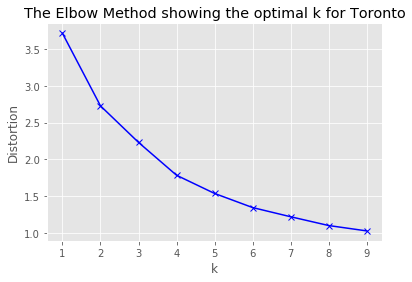

In [199]:
# clustering dataset
# determine k using elbow method
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)
    distortions.append(kmeans.inertia_)

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k for Toronto')
plt.show()

This time the curve is more smooth, we decided to pick k = 4 for clustering.

In [200]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [202]:
neighborhoods_venues_sorted2.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_data_filtered.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)
toronto_merged = toronto_data_filtered

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted2.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Trail,Pub,Yoga Studio,Department Store
1,M4K,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Restaurant,Ice Cream Shop
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0,Park,Sandwich Place,Fish & Chips Shop,Ice Cream Shop,Food & Drink Shop
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Gastropub,Brewery,Bakery
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Dim Sum Restaurant,Park,Bus Line,Swim School,Yoga Studio


Visualize the resulting clusters.

In [203]:
# create map
map_clusters2 = folium.Map(location=[43.653963, -79.387207], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

Now, we can examine each cluster in Toronto.

#### Toronto - Cluster 1

In [204]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,East Toronto,0,Health Food Store,Trail,Pub,Yoga Studio,Department Store
1,East Toronto,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Restaurant,Ice Cream Shop
2,East Toronto,0,Park,Sandwich Place,Fish & Chips Shop,Ice Cream Shop,Food & Drink Shop
3,East Toronto,0,Café,Coffee Shop,Gastropub,Brewery,Bakery
4,Central Toronto,0,Dim Sum Restaurant,Park,Bus Line,Swim School,Yoga Studio
5,Central Toronto,0,Hotel,Park,Gym,Breakfast Spot,Department Store
6,Central Toronto,0,Coffee Shop,Sporting Goods Shop,Yoga Studio,Italian Restaurant,Clothing Store
7,Central Toronto,0,Sandwich Place,Dessert Shop,Pizza Place,Italian Restaurant,Café
9,Central Toronto,0,Coffee Shop,Pub,Pizza Place,American Restaurant,Restaurant
11,Downtown Toronto,0,Coffee Shop,Restaurant,Italian Restaurant,Pizza Place,Chinese Restaurant


#### Toronto - Cluster 2

In [205]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,Central Toronto,1,Playground,Summer Camp,Yoga Studio,Dessert Shop,Event Space


#### Toronto - Cluster 3

In [206]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
22,Central Toronto,2,Garden,Yoga Studio,Dessert Shop,Falafel Restaurant,Event Space


#### Toronto - Cluster 4

In [207]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,Downtown Toronto,3,Park,Playground,Trail,Yoga Studio,Department Store
23,Central Toronto,3,Park,Jewelry Store,Trail,Sushi Restaurant,Yoga Studio


#### Shanghai main area data

In [18]:
# one hot encoding
sh_onehot = pd.get_dummies(sh_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sh_onehot['Neighborhood'] = sh_venues['Neighborhood'] 
# move neighborhood column to the first column
sh_onehot = sh_onehot[ ['Neighborhood'] + [ col for col in sh_onehot.columns if col != 'Neighborhood' ] ]

sh_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Athletics & Sports,BBQ Joint,Bakery,Bar,Big Box Store,Bistro,...,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant
0,Huangpu,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Huangpu,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Huangpu,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Huangpu,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Huangpu,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [19]:
sh_grouped = sh_onehot.groupby('Neighborhood').mean().reset_index()
sh_grouped

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Athletics & Sports,BBQ Joint,Bakery,Bar,Big Box Store,Bistro,...,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant
0,Baoshan,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,...,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000
1,Changning,0.000000,0.00,0.00,0.015385,0.046154,0.015385,0.00,0.000000,0.00,...,0.00,0.015385,0.00,0.00,0.00,0.00,0.015385,0.00,0.00,0.000000
2,Fengxian,0.000000,0.00,0.00,0.000000,0.100000,0.000000,0.00,0.000000,0.00,...,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000
3,Hongkou,0.000000,0.00,0.00,0.000000,0.000000,0.030303,0.00,0.000000,0.00,...,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000
4,Huangpu,0.010000,0.01,0.01,0.000000,0.020000,0.010000,0.03,0.000000,0.00,...,0.00,0.000000,0.01,0.00,0.01,0.00,0.010000,0.00,0.01,0.000000
5,Jiading,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,...,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000
6,Jing'an,0.000000,0.00,0.00,0.000000,0.000000,0.040000,0.02,0.000000,0.01,...,0.01,0.020000,0.00,0.01,0.02,0.01,0.010000,0.01,0.00,0.000000
7,Jinshan,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,...,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000
8,Minhang,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,...,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.076923
9,Pudong New Area,0.043478,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,...,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000


In [33]:
sh_venue_type = list(sh_grouped.columns.values)
sh_food = []
sh_culture = []
for i in range(0, len(sh_venue_type)):
    for food in food_words:
        if food in sh_venue_type[i]:
            sh_food.append(sh_venue_type[i])
    for culture in culture_words:
        if culture in sh_venue_type[i]:
            sh_culture.append(sh_venue_type[i])

print('You can find the following types of food @Shanghai:')
print(sh_food)
print('\n')
print('You can find the following types of cultural places @Shanghai:')
print(sh_culture)

You can find the following types of food @Shanghai:
['American Restaurant', 'Brazilian Restaurant', 'Cantonese Restaurant', 'Chinese Restaurant', 'Dim Sum Restaurant', 'Dumpling Restaurant', 'English Restaurant', 'Fast Food Restaurant', 'French Restaurant', 'Hotpot Restaurant', 'Hunan Restaurant', 'Indian Restaurant', 'Italian Restaurant', 'Japanese Restaurant', 'Kebab Restaurant', 'Korean Restaurant', 'Malay Restaurant', 'Mexican Restaurant', 'Modern European Restaurant', 'New American Restaurant', 'Peking Duck Restaurant', 'Polish Restaurant', 'Ramen Restaurant', 'Restaurant', 'Seafood Restaurant', 'Shanghai Restaurant', 'Spanish Restaurant', 'Steakhouse', 'Sushi Restaurant', 'Szechuan Restaurant', 'Tapas Restaurant', 'Thai Restaurant', 'Vegetarian / Vegan Restaurant', 'Vietnamese Restaurant', 'Xinjiang Restaurant', 'Yunnan Restaurant', 'Zhejiang Restaurant']


You can find the following types of cultural places @Shanghai:
['Art Gallery', 'Art Gallery', 'Art Museum', 'Art Museum', 'B

In [211]:
for hood in sh_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sh_grouped[sh_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Baoshan----
                  venue  freq
0  Fast Food Restaurant  0.33
1         Metro Station  0.33
2              Bus Stop  0.33
3   American Restaurant  0.00
4          Noodle House  0.00


----Changning----
                  venue  freq
0   Japanese Restaurant  0.22
1           Coffee Shop  0.12
2  Fast Food Restaurant  0.07
3          Noodle House  0.06
4    Chinese Restaurant  0.04


----Fengxian----
                  venue  freq
0  Fast Food Restaurant  0.11
1           Bus Station  0.11
2                Market  0.11
3    Seafood Restaurant  0.11
4             BBQ Joint  0.11


----Hongkou----
                  venue  freq
0           Coffee Shop  0.17
1  Fast Food Restaurant  0.08
2         Shopping Mall  0.06
3                 Plaza  0.06
4           Pizza Place  0.06


----Huangpu----
                venue  freq
0               Hotel  0.13
1   French Restaurant  0.07
2              Lounge  0.06
3  Italian Restaurant  0.04
4         Coffee Shop  0.04


----Jiading----
   

In [226]:
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted3 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted3['Neighborhood'] = sh_grouped['Neighborhood']

for ind in np.arange(sh_grouped.shape[0]):
    neighborhoods_venues_sorted3.iloc[ind, 1:] = return_most_common_venues(sh_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted3.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Baoshan,Fast Food Restaurant,Metro Station,Bus Stop,Zhejiang Restaurant,Gym Pool,English Restaurant,Farmers Market,Flower Shop,Food & Drink Shop,Food Truck
1,Changning,Japanese Restaurant,Coffee Shop,Fast Food Restaurant,Noodle House,Hotel,Chinese Restaurant,BBQ Joint,Ramen Restaurant,Shopping Mall,Clothing Store
2,Fengxian,Market,Fast Food Restaurant,Grocery Store,Clothing Store,BBQ Joint,Seafood Restaurant,Bar,Bus Station,Convenience Store,Furniture / Home Store
3,Hongkou,Coffee Shop,Fast Food Restaurant,Shopping Mall,Pizza Place,Plaza,Noodle House,Taiwanese Restaurant,Chinese Restaurant,Ramen Restaurant,Multiplex
4,Huangpu,Hotel,French Restaurant,Lounge,Chinese Restaurant,Restaurant,Italian Restaurant,Coffee Shop,Shopping Mall,Clothing Store,Bar


Build a for loop to search for the optimal number for k-means clustering.

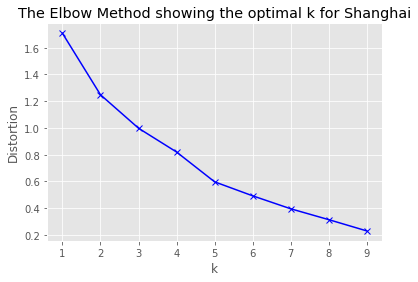

In [35]:
# clustering dataset
# determine k using elbow method
sh_grouped_clustering = sh_grouped.drop('Neighborhood', 1)

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(sh_grouped_clustering)
    distortions.append(kmeans.inertia_)

# Plot the elbow
plt.style.use('ggplot')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k for Shanghai')
plt.show()

This curve looks more similar to that of Toronto. k = 5 seems to be a better choice.

In [216]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sh_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 1, 1, 1, 1, 3, 1, 1], dtype=int32)

In [227]:
# add clustering labels
neighborhoods_venues_sorted3.insert(0, 'Cluster Labels', kmeans.labels_)
sh_merged = district_info

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
sh_merged = sh_merged.join(neighborhoods_venues_sorted3.set_index('Neighborhood'), on='Neighborhood')
sh_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Huangpu,31.233593,121.479864,1,Hotel,French Restaurant,Lounge,Chinese Restaurant,Restaurant,Italian Restaurant,Coffee Shop,Shopping Mall,Clothing Store,Bar
1,Xuhui,31.163698,121.427994,1,Fast Food Restaurant,Hotel,Sushi Restaurant,Chinese Restaurant,Shopping Mall,Coffee Shop,Zhejiang Restaurant,Bakery,Hotpot Restaurant,Pizza Place
2,Changning,31.209276,121.389986,1,Japanese Restaurant,Coffee Shop,Fast Food Restaurant,Noodle House,Hotel,Chinese Restaurant,BBQ Joint,Ramen Restaurant,Shopping Mall,Clothing Store
3,Jing'an,31.229776,121.443060,1,Hotel Bar,Coffee Shop,Hotel,Shopping Mall,Bakery,Italian Restaurant,Gym / Fitness Center,Lounge,Japanese Restaurant,French Restaurant
4,Putuo,31.251326,121.391229,4,Seafood Restaurant,Soccer Field,Flower Shop,Food Truck,Chinese Restaurant,Supermarket,Zhejiang Restaurant,Dim Sum Restaurant,Electronics Store,English Restaurant


In [228]:
# create map
map_clusters3 = folium.Map(location=[31.2322758, 121.4692071], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sh_merged['Latitude'], sh_merged['Longitude'], sh_merged['Neighborhood'], sh_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters3)
       
map_clusters3

Now, we can examine each cluster in Shanghai.

#### Shanghai - Cluster 1

In [229]:
sh_merged.loc[sh_merged['Cluster Labels'] == 0, sh_merged.columns[[0] + list(range(3, sh_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Baoshan,0,Fast Food Restaurant,Metro Station,Bus Stop,Zhejiang Restaurant,Gym Pool,English Restaurant,Farmers Market,Flower Shop,Food & Drink Shop,Food Truck


#### Shanghai - Cluster 2

In [230]:
sh_merged.loc[sh_merged['Cluster Labels'] == 1, sh_merged.columns[[0] + list(range(3, sh_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Huangpu,1,Hotel,French Restaurant,Lounge,Chinese Restaurant,Restaurant,Italian Restaurant,Coffee Shop,Shopping Mall,Clothing Store,Bar
1,Xuhui,1,Fast Food Restaurant,Hotel,Sushi Restaurant,Chinese Restaurant,Shopping Mall,Coffee Shop,Zhejiang Restaurant,Bakery,Hotpot Restaurant,Pizza Place
2,Changning,1,Japanese Restaurant,Coffee Shop,Fast Food Restaurant,Noodle House,Hotel,Chinese Restaurant,BBQ Joint,Ramen Restaurant,Shopping Mall,Clothing Store
3,Jing'an,1,Hotel Bar,Coffee Shop,Hotel,Shopping Mall,Bakery,Italian Restaurant,Gym / Fitness Center,Lounge,Japanese Restaurant,French Restaurant
5,Hongkou,1,Coffee Shop,Fast Food Restaurant,Shopping Mall,Pizza Place,Plaza,Noodle House,Taiwanese Restaurant,Chinese Restaurant,Ramen Restaurant,Multiplex
6,Yangpu,1,Coffee Shop,Chinese Restaurant,Seafood Restaurant,Bakery,Park,Cantonese Restaurant,Hotel,Zhejiang Restaurant,Garden,Furniture / Home Store
7,Minhang,1,Coffee Shop,Fast Food Restaurant,Zhejiang Restaurant,Burger Joint,Dessert Shop,Park,Shopping Mall,Clothing Store,Multiplex,Plaza
9,Jiading,1,Coffee Shop,Japanese Restaurant,History Museum,Pizza Place,Shopping Plaza,Garden,Grocery Store,Movie Theater,Historic Site,Café
10,Pudong New Area,1,Hotel,Grocery Store,Coffee Shop,American Restaurant,Sports Bar,Lounge,Massage Studio,Gymnastics Gym,Mexican Restaurant,New American Restaurant
12,Songjiang,1,Hotel,Big Box Store,Metro Station,Fast Food Restaurant,Park,Convenience Store,Coffee Shop,Garden,Furniture / Home Store,French Restaurant


#### Shanghai - Cluster 3

In [231]:
sh_merged.loc[sh_merged['Cluster Labels'] == 2, sh_merged.columns[[0] + list(range(3, sh_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Qingpu,2,Department Store,Playground,Coffee Shop,Hotel,Zhejiang Restaurant,Gym,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop


#### Shanghai - Cluster 4

In [232]:
sh_merged.loc[sh_merged['Cluster Labels'] == 3, sh_merged.columns[[0] + list(range(3, sh_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Jinshan,3,Convenience Store,Burger Joint,Zhejiang Restaurant,Gym / Fitness Center,English Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Food Truck


#### Shanghai - Cluster 5

In [233]:
sh_merged.loc[sh_merged['Cluster Labels'] == 4, sh_merged.columns[[0] + list(range(3, sh_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Putuo,4,Seafood Restaurant,Soccer Field,Flower Shop,Food Truck,Chinese Restaurant,Supermarket,Zhejiang Restaurant,Dim Sum Restaurant,Electronics Store,English Restaurant


In [245]:
# create map
map_clusters4 = folium.Map(location=[31.2322758, 121.4692071], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sh_merged['Latitude'], sh_merged['Longitude'], sh_merged['Neighborhood'], sh_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters4)

for lat, lng, label in zip(univ_info['Latitude'], univ_info['Longitude'], univ_info['University']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='black',
        fill=True,
        fill_color='gray',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters4)  
       
map_clusters4

## Results and Discussion <a name="results"></a>

Our analysis shows that even though NYC Manhattan area is the smallest among the three (87 km<sup>2</sup> vs Toronto 630 km<sup>2</sup> vs Shanghai 660 km<sup>2</sup>), it possesses the highest diversity of venues. 337 unique venue categories were found in NYC, while only 231 and 117 were found in Toronto and Shanghai separately.

The food diversity in Manhattan is incredible. Cuisines from nearly every continent can be found there, such as North America (American, Cuban), South America (Brazilian, Argentinian), Europe (Scandinavian, Mediterranean), Africa (Ethiopian), Asia (Vietnamese, Israeli), and Oceania (Australian), without even mentioning the well-spreaded styles such as French and Japanese. There are even modern restaurants that sound more for the fun experience than for the food, such as molecular gastronomy restaurant and theme restaurant. In Toronto, the places of origin of the cuisines are more from North and South America, Europe, and Asia. Shanghai has the least number of food options, but one can find very specific types of Asian food there. For example, there are cuisines from many different provinces in China (Peking, Hunan, Xinjiang, Yunan, Cantonese) and different Asian countries (Thai, Malay, Indian).

The culture-related places found in the three cities are similar. There are art galleries, art and history museums, bookstores, and music venues. In NYC and Toronto, we also found antique shops and crafts stores. Again, NYC provides people with more casual places such as street art and used bookstores. Therefore, NYC might be a better place for people who are looking for a little bit of new experience of everything.

The smooth curves found with the elbow method inform that the whole area in the three cities are generally similar, which makes it hard to draw a line between neighborhoods. Taking a closer look at the detailed categories in each cluster, we could see that the clusters that dominate in the cities are all urban areas. This is not too surprising since the three cities are all modern metroplis. Those areas are convenient for people to get food and drinks, buy stuff, and commute to work. For people who come for short visits, there are many hotels around for them to stay in. In Manhattan, there are also neighborhoods featuring theaters, which contains the world-famous broadway. In NYC and Toronto, we could see neighborhoods mainly containing natural places such as parks, where people can enjoy themselves during weekends. Unfortunately, this is not the case for Shanghai.

From the map showing locations of universities in Shanghai, we could see that the density of higher education institutes is relatively high and the locations of the universities are nearly overlapped with the neighborhoods included in the main cluster. This means that the food and store concentrated areas in Shanghai could also developed to meet the need of those students.

Geographically, the three big cities all face water on at least one side. Shanghai and Toronto both have humid continental climate, while NYC locates in between the humid subtropical and the humid continental climate regions. The three cities all see four seasons and a temperature change over 40 °F throughout the year, with Toronto being the coldest. The average temperature in Toronto falls below freezing point of water in December through February, which might need to be undesirable for people come from warm area.

## Conclusion <a name="conclusion"></a>

In this project, we were trying to compare the venues data of neighborhoods in the main areas of NYC, Toronto, and Shanghai to help people who are seeking for a new home in a metroplis decide which one of the three cities might be a better choice. Based on the clustering result of Foursquare data, we saw that the metropolitan cities are quite similar to each other.

NYC offers the most diverse choices for people from any background. For those who would like to try new things everyday, this might be the top choice among the three. Toronto is featured more for the balance between urban and natural areas. Even though NYC and Toronto both have park rich areas, the density of venues is much lower in Toronto, which makes it less crowded there. For people who prefer warmer area or an extensive experience of asian culture, Shanghai is recommended.

There is a saying that people will vote for their dream home with their feet by walking there. The final decision is up to everybody. Considering the location, food, climate, activities, and education, people will certainly find their unique lives.

### Reference

1. [Which Cities Are The World's Financial Centers?](https://www.worldatlas.com/articles/the-world-s-top-financial-cities.html)
2. [Toronto - Wikipedia](https://en.wikipedia.org/wiki/Toronto)
3. [New York City - Wikipedia](https://en.wikipedia.org/wiki/New_York_City)
4. [Shanghai - Wikipedia](https://en.wikipedia.org/wiki/Shanghai)
5. [List of administrative divisions of Shanghai](https://en.wikipedia.org/wiki/List_of_administrative_divisions_of_Shanghai)
6. [List of universities and colleges in Shanghai](https://en.wikipedia.org/wiki/List_of_universities_and_colleges_in_Shanghai)
7. [New York City average temperature by month](https://www.currentresults.com/Weather/New-York/Places/new-york-city-temperatures-by-month-average.php)
8. [Toronto average temperature by month](https://www.currentresults.com/Weather/Canada/Ontario/Places/toronto-temperatures-by-month-average.php)
9. [Shanghai average temperature by month](https://www.holiday-weather.com/shanghai/averages/)